# Import

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import random
import os
from pymol import cmd
from collections import defaultdict, Counter 
from sklearn.preprocessing import MinMaxScaler
from Bio.SeqUtils import seq1
from Bio import SeqIO # to read sequences from a FASTA file
from Bio import pairwise2 # pairwise sequence alignments
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

import matplotlib.cm as cm
from scipy.stats import kruskal
from itertools import combinations
from scipy.stats import mannwhitneyu



plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['axes.titleweight'] = 'bold'


/opt/anaconda3/envs/epitope_env/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


# Do cluster have different binding affinities? 

In [11]:
section = 'paratope' 

all_df.rename(columns={"folder": "checkpoint"}, inplace=True)

all_df = pd.read_csv(f"data/structural_analysis/{section.capitalize()}/structural_{section}_all_information_final.csv")

if section.lower() == "paratope":
    manual_clusters = {
    "Cluster 1": ["5b8c", "5ggs"],
    "Cluster 2": ["9dq4", "9dq3", "5tru", "7su0", "7su1", "5jx3", "6rp8"],
    "Cluster 3": ["5ggr", "5wt9", "5ggv", "7bxa", "7cgw"],
    "Cluster 4": ["5x8l", "5xxy"],
    "Cluster 5": ["6txz"],
    "Cluster 6": ["7wvm", "8gy5"],
    }
else: 
    manual_clusters = {
    "Cluster 1": ["7su1", "6rp8", "7su0", "5tru", "5xj3", "9dq3", "5ggv", "9dq4"],
    "Cluster 2": ["6txz"],
    "Cluster 3": ["5grj", "5x8m", "5xj4", "5x8l", "5xxy"],
    "Cluster 4": ["5ggs", "5b8c", "7bxa", "6xkr", "5jxe", "7cgw"],
    "Cluster 5": ["6k0y", "5wt9", "5ggr", "7cu5", "8gy5", "7wsl", "7wvm"],

}

# Convert manual Cluster-Dict in list 
cluster_rows = []
for cluster_name, pdb_list in manual_clusters.items():
    for pdb in pdb_list:
        cluster_rows.append({"pdb_id": pdb, "cluster": cluster_name})

# DF
cluster_df = pd.DataFrame(cluster_rows)

# 3. Merge with main df 
merged_df = cluster_df.merge(all_df[["pdb_id", "binding_score", "folder"]], on="pdb_id", how="left")

print(merged_df)

   pdb_id    cluster  binding_score folder
0    5b8c  Cluster 1       0.132989    pd1
1    5b8c  Cluster 1       0.132989    pd1
2    5b8c  Cluster 1       0.132989    pd1
3    5b8c  Cluster 1       0.132989    pd1
4    5ggs  Cluster 1       0.289538    pd1
5    5ggs  Cluster 1       0.289538    pd1
6    9dq4  Cluster 2       0.951521  ctla4
7    9dq3  Cluster 2       0.376213  ctla4
8    5tru  Cluster 2       0.101403  ctla4
9    5tru  Cluster 2       0.101403  ctla4
10   7su0  Cluster 2       0.142831  ctla4
11   7su0  Cluster 2       0.142831  ctla4
12   7su1  Cluster 2       0.313449  ctla4
13   5jx3  Cluster 2            NaN    NaN
14   6rp8  Cluster 2       0.091634  ctla4
15   6rp8  Cluster 2       0.091634  ctla4
16   5ggr  Cluster 3       0.099924    pd1
17   5ggr  Cluster 3       0.099924    pd1
18   5wt9  Cluster 3       0.099323    pd1
19   5ggv  Cluster 3       0.137464  ctla4
20   7bxa  Cluster 3       0.107298    pd1
21   7bxa  Cluster 3       0.107298    pd1
22   7cgw  

/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_31305/3831050858.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x="cluster", y="binding_score", palette="Set2")
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Fo

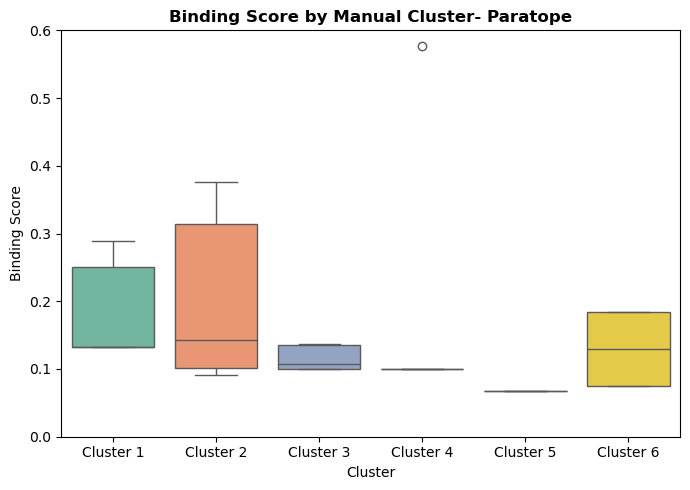

In [12]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=merged_df, x="cluster", y="binding_score", palette="Set2")

plt.title(f"Binding Score by Manual Cluster- {section.capitalize()}")
plt.xlabel("Cluster")
plt.ylabel("Binding Score")
plt.tight_layout()
plt.ylim(0, 0.6)

plt.savefig(f"plots/structural_analysis/statistical_analysis/{section.capitalize()}/{section}_binding_score_by_cluster.pdf", bbox_inches='tight')


In [13]:
# group by cluster 
grouped_scores = [
    group["binding_score"].dropna().values
    for name, group in merged_df.groupby("cluster")
]

# Kruskal–Wallis-Test
stat, p = kruskal(*grouped_scores)

print(f"Kruskal–Wallis-Test: H = {stat:.3f}, p = {p:.4e}")

Kruskal–Wallis-Test: H = 13.589, p = 1.8440e-02


/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_31305/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Fon

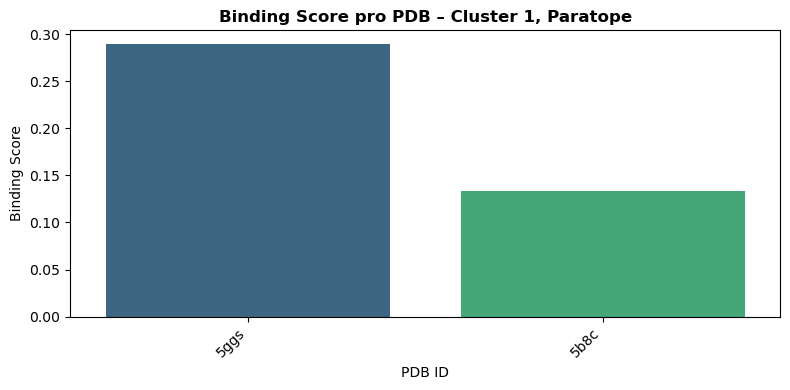

/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_31305/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Fon

<Figure size 640x480 with 0 Axes>

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

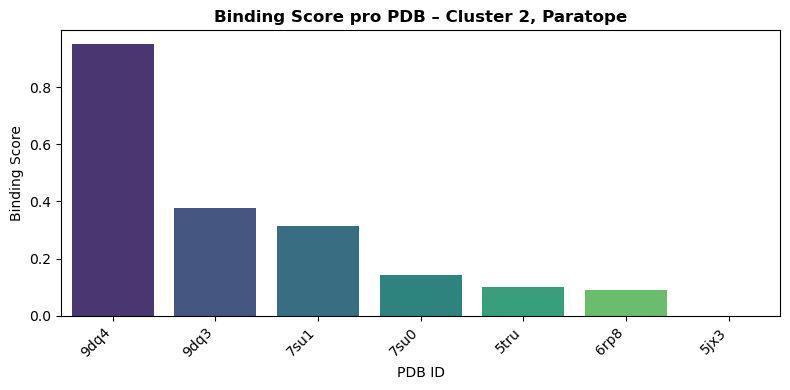

/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_31305/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Fon

<Figure size 640x480 with 0 Axes>

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

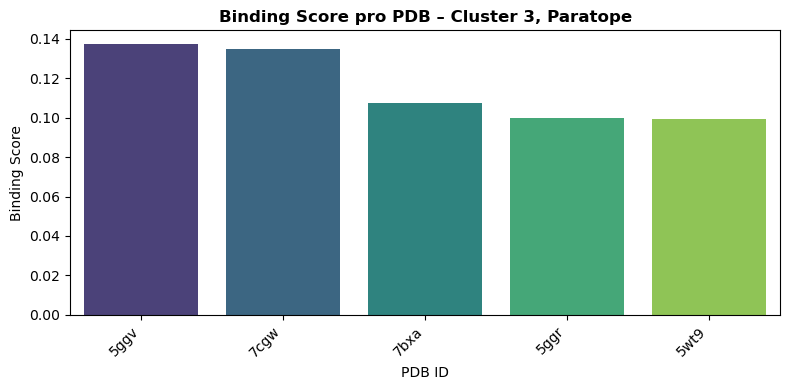

/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_31305/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.


<Figure size 640x480 with 0 Axes>

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

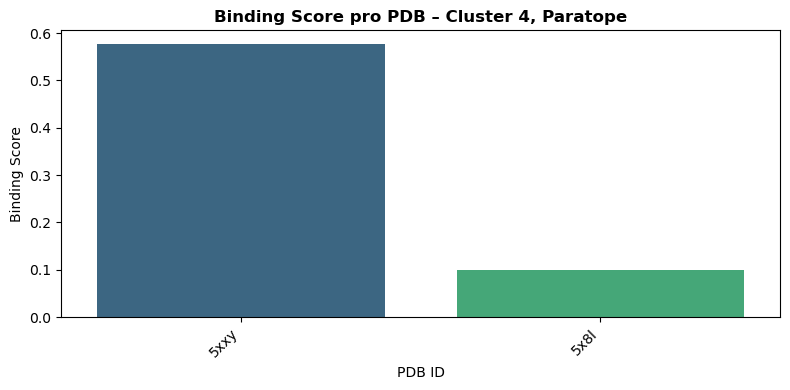

/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_31305/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.


<Figure size 640x480 with 0 Axes>

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

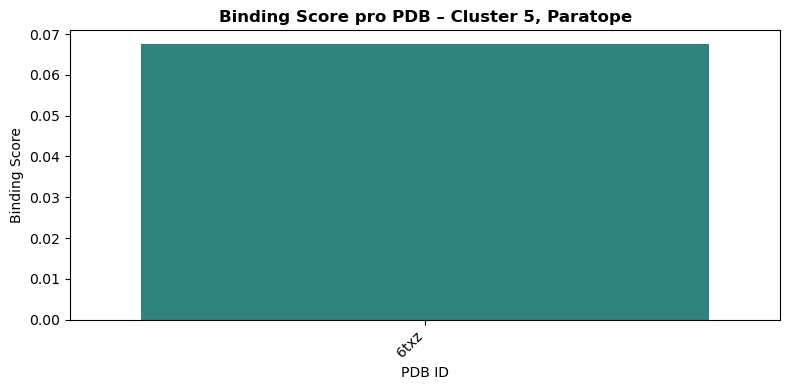

/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_31305/2561669429.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.


<Figure size 640x480 with 0 Axes>

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

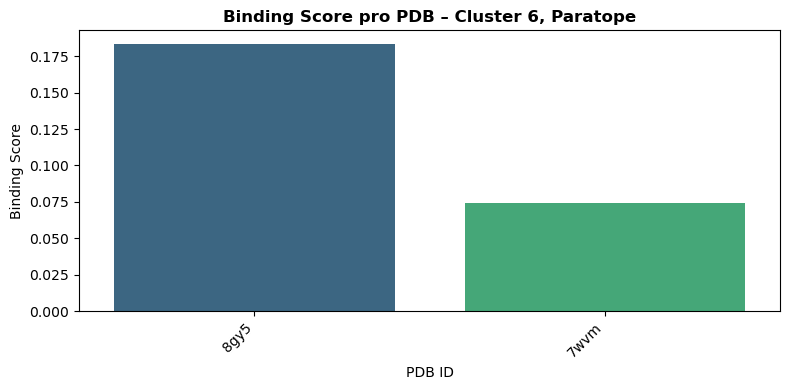

<Figure size 640x480 with 0 Axes>

In [15]:
clusters = merged_df["cluster"].unique()

# Plot per Cluster
for cluster_name in clusters:
    subset = merged_df[merged_df["cluster"] == cluster_name].sort_values("binding_score", ascending=False)

    plt.figure(figsize=(8, 4))
    sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
    plt.title(f"Binding Score pro PDB – {cluster_name}, {section.capitalize()}")
    plt.xlabel("PDB ID")
    plt.ylabel("Binding Score")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    plt.savefig(f"plots/structural_analysis/statistical_analysis/{section.capitalize()}/{section}_Binding Score pro PDB – {cluster_name}.pdf", bbox_inches='tight')



In [17]:
all_df.rename(columns={"folder": "checkpoint"}, inplace=True)

/var/folders/vf/ygq5vvrx3fbcsv9n_5277nmr0000gn/T/ipykernel_31305/1637604492.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_binding_pairs, x="group", y="mean_binding", palette=["#66c2bf", "#fc626c"])
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' no

Mann–Whitney U-Statistik: 52224.00
P-Wert: 0.0094


findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.


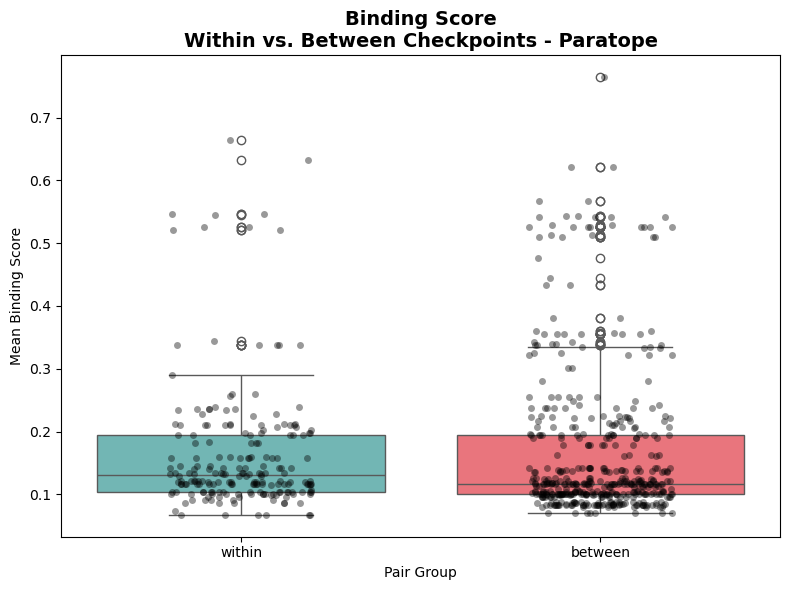

In [19]:
# Drop NaNs in binding_score or checkpoint 
clean_df = merged_df.dropna(subset=["binding_score", "folder"])

# Generate all pairwise combinations
pairs = []
for (p1, row1), (p2, row2) in combinations(clean_df.iterrows(), 2):
    score1 = row1["binding_score"]
    score2 = row2["binding_score"]

    if pd.notna(score1) and pd.notna(score2):
        pairs.append({
            "pdb_1": row1["pdb_id"],
            "pdb_2": row2["pdb_id"],
            "mean_binding": (score1 + score2) / 2,
            "same_checkpoint": row1["folder"] == row2["folder"]
        })

# Create DataFrame and group labels
df_binding_pairs = pd.DataFrame(pairs)
df_binding_pairs = df_binding_pairs.dropna(subset=["mean_binding"])
df_binding_pairs["group"] = df_binding_pairs["same_checkpoint"].map({True: "within", False: "between"})

# Statistical test
within = df_binding_pairs[df_binding_pairs["group"] == "within"]["mean_binding"]
between = df_binding_pairs[df_binding_pairs["group"] == "between"]["mean_binding"]

stat, p = mannwhitneyu(within, between, alternative="greater")
print(f"Mann–Whitney U-Statistik: {stat:.2f}")
print(f"P-Wert: {p:.4f}")

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_binding_pairs, x="group", y="mean_binding", palette=["#66c2bf", "#fc626c"])
sns.stripplot(data=df_binding_pairs, x="group", y="mean_binding", color='black', alpha=0.4, jitter=0.2)

plt.title(f"Binding Score\nWithin vs. Between Checkpoints - {section.capitalize()}", fontsize=14)
plt.ylabel("Mean Binding Score")
plt.xlabel("Pair Group")
plt.tight_layout()
plt.show()


In [ ]:
df.identiy= pd.read_csv(f"datastructural_analysis")
df_identity.index = df_identity.index.str.lower()
df_identity.columns = df_identity.columns.str.lower()
merged_df["pdb_id"] = merged_df["pdb_id"].str.lower()
print(df_identity)

NameError: name 'df_identity' is not defined

In [ ]:
pairs = []

# Extrahiere nur die echten PDB-IDs aus dem df_identity-Index
# Annahme: Format ist "checkpoint | pdb_id"
df_identity.index = df_identity.index.str.extract(r"\|\s*(.*)")[0]
df_identity.columns = df_identity.columns.str.extract(r"\|\s*(.*)")[0]

# Iteriere über alle PDB-Paare
for pdb1, pdb2 in combinations(df_identity.index, 2):
    if pdb1 not in merged_df["pdb_id"].values or pdb2 not in merged_df["pdb_id"].values:
        continue  # Wenn einer fehlt, skip
    
    identity = df_identity.loc[pdb1, pdb2]
    
    # Hole die Checkpoints
    cp1 = merged_df[merged_df["pdb_id"] == pdb1]["checkpoint"]
    cp2 = merged_df[merged_df["pdb_id"] == pdb2]["checkpoint"]
    
    if cp1.empty or cp2.empty:
        continue
    
    group1 = cp1.values[0]
    group2 = cp2.values[0]
    same_group = group1 == group2

    pairs.append({
        "pdb1": pdb1,
        "pdb2": pdb2,
        "identity": identity,
        "same_checkpoint": same_group
    })

# Speichern in DataFrame
df_pairs = pd.DataFrame(pairs)

In [ ]:
from scipy.stats import mannwhitneyu

within = df_pairs[df_pairs["same_checkpoint"] == True]["identity"]
between = df_pairs[df_pairs["same_checkpoint"] == False]["identity"]

stat, p = mannwhitneyu(within, between, alternative="greater")
print(f"Mann–Whitney U-Statistik: {stat:.2f}")
print(f"P-Wert: {p:.4f}")


In [ ]:
# Falls noch nicht vorhanden: 'same_checkpoint' als bool-Typ sichern
df_pairs["same_checkpoint"] = df_pairs["same_checkpoint"].astype(bool)

# Ersetze True/False durch beschreibende Labels
df_pairs["group"] = df_pairs["same_checkpoint"].map({True: "within", False: "between"})

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_pairs, x="group", y="identity", palette=["#66c2bf", "#fc626c"])
sns.stripplot(data=df_pairs, x="group", y="identity", color='black', alpha=0.4, jitter=0.2)
plt.title(f"{section.capitalize()} Sequence Identity\nWithin vs. Between Checkpoints", fontsize=14)
plt.ylabel("Sequence Identity (%)")
plt.xlabel("Pair Group")
plt.tight_layout()
plt.show()


In [ ]:
wanted_best_pdbs = ['5xj4', '5x8m', '7bxa', '7cgw', '5b8c', '5ggs', '5jxe', '5x8l',
       '5xxy', '5wt9', '5ggr']

filtered_best_df = all_df[all_df['pdb_id'].isin(wanted_best_pdbs)]

filtered_best_df.to_csv(f'data/structural_analysis/statistical_analysis/{section.capitalize()}/{section}_filtered_pdbs_best.csv', index=False)

In [ ]:
wanted_worst_pdbs = ['7wsl', '7wvm', '8gy5', '5grj', '6rp8', '5xj3', '9dq4', '7su0',
       '5tru', '7su1', '9dq3']

filtered_worst_df = all_df[all_df['pdb_id'].isin(wanted_best_pdbs)]

filtered_worst_df.to_csv(f'data/structural_analysis/statistical_analysis/{section.capitalize()}/{section}_filtered_pdbs_worst.csv', index=False)